In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install -q -U git+https://github.com/sbrugman/SDGym.git@v0.2.2-hw

In [ ]:
!pip install -q -U ../../

In [2]:
from timeit import default_timer as timer
from functools import partial
from random import choices
import logging

In [3]:
import sdgym
from sdgym import load_dataset
from sdgym import benchmark
from sdgym import load_dataset

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [5]:
import pgmpy

from pgmpy.models import BayesianModel
from pgmpy.estimators import TreeSearch, HillClimbSearch, BicScore, ExhaustiveSearch, BayesianEstimator
from pgmpy.sampling import BayesianModelSampling

In [6]:
import xgboost as xgb
from xgboost import XGBClassifier

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression

In [8]:
from scipy import interpolate

In [9]:
from synthsonic.models.kde_utils import kde_smooth_peaks_1dim, kde_smooth_peaks
from synthsonic.models.kde_copula_nn_pdf import KDECopulaNNPdf

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
logging.basicConfig(level=logging.INFO)

In [21]:
dataset_name = 'news_categorical'
dataset_name = 'news'

In [22]:
data, categorical_columns, ordinal_columns = load_dataset(dataset_name)

#model = CopulaGAN()
#model._MODEL_KWARGS['epochs'] = 1
#model.fit(data, categorical_columns, ordinal_columns)
#distributions = model.get_distributions()

INFO:sdgym.data:Loading dataset news (all variables, -1 distinct values threshold)
INFO:sdgym.data:Columns to zero-code: []


In [23]:
categorical_columns, ordinal_columns

([11, 12, 13, 14, 15, 16, 29, 30, 31, 32, 33, 34, 35, 36], [])

In [24]:
len(categorical_columns), len(ordinal_columns), data.shape[1]

(14, 0, 59)

In [25]:
for i in range(data.shape[1]):
    print (i, len(np.unique(data[:, i])))

0 19
1 2283
2 18868
3 4
4 14365
5 125
6 59
7 87
8 52
9 24931
10 10
11 2
12 2
13 2
14 2
15 2
16 2
17 23
18 1057
19 14928
20 974
21 33
22 25559
23 13325
24 16673
25 31370
26 1216
27 1094
28 7244
29 2
30 2
31 2
32 2
33 2
34 2
35 2
36 2
37 26420
38 27654
39 26397
40 26581
41 25361
42 27892
43 28041
44 11548
45 9064
46 2077
47 2077
48 22347
49 33
50 38
51 11715
52 53
53 49
54 603
55 724
56 479
57 581
58 1353


(array([2.7514e+04, 2.3470e+03, 7.6400e+02, 3.5500e+02, 1.9500e+02,
        1.1500e+02, 7.0000e+01, 4.3000e+01, 3.8000e+01, 3.6000e+01,
        3.2000e+01, 2.4000e+01, 1.0000e+01, 1.0000e+01, 1.0000e+01,
        8.0000e+00, 7.0000e+00, 3.0000e+00, 4.0000e+00, 1.2000e+01,
        3.0000e+00, 4.0000e+00, 6.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([1.00000000e+00, 4.94097510e+03, 9.88095020e+03, 1.48209248e+04,
        1.97609004e+04, 2.47008750e+04, 2.96408496e+04, 3.45808242e+04,
        3.95208008e+04, 4.44607734e+04, 4.94007500e+04, 5.43407266e+04,
        5.92806992e+04, 6.42206758e+04, 6.91606484e+04, 7.41006250e+04,
        7.90406016e+04, 8.39805781e+04, 8.89205469e+04, 9.38605234e+04,
        9.88005000e+04, 1.03740477e+05, 1.08680453e+05, 1.13620422e+05,
        1.18560398e+05

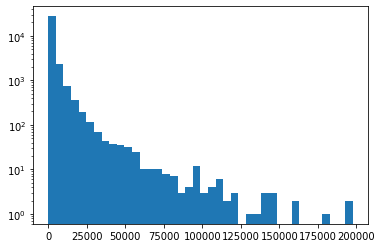

In [34]:
x = data[:, 58]
plt.hist(x[x < 200000], bins=40, log=True)

In [30]:
np.min(x), np.max(x)

(1.0, 843300.0)

# run sdgym

In [50]:
def KDECopulaNNPdf_Synthesizer(real_data, categorical_columns, ordinal_columns):
    # assert len(categorical_columns + ordinal_columns) <= 1

    all_features = list(range(real_data.shape[1]))
    numerical_features = list(set(all_features) - set(categorical_columns + ordinal_columns))
    data = np.float64(real_data)
    
    n_samples = data.shape[0]
    n_features = data.shape[1]
    
    clf = xgb.XGBClassifier(
        n_estimators=250,
        reg_lambda=1,
        gamma=0,
        max_depth=9
    )
#     clf = MLPClassifier(alpha=0.1, random_state=0, max_iter=1000, early_stopping=True)
    
    kde = KDECopulaNNPdf(
        use_KDE=False, 
        categorical_columns=categorical_columns+ordinal_columns,
        distinct_threshold=-1,
        n_bins=25,
        # clf=clf,
        # ordering='mi',
    )
    kde = kde.fit(data)
    
#     X_gen, sample_weight = kde.sample(n_samples)
    X_gen = kde.sample_no_weights(n_samples, show_progress=True, mode='cheap')
    
    X_gen[:, categorical_columns+ordinal_columns] = np.round(X_gen[:, categorical_columns+ordinal_columns])
    X_gen = np.float32(X_gen)
    
    print(X_gen[:, :5])

    return X_gen

In [51]:
def KDECopulaNNPdf_SynthesizerInteger(real_data, categorical_columns, ordinal_columns):
    """Census has integer only..."""
    data = KDECopulaNNPdf_Synthesizer(real_data, categorical_columns, ordinal_columns)
    data = np.round(data)
    
    print(data[:, :5])

    return data

In [52]:
from sdgym.synthesizers import (
    CLBNSynthesizer, CTGANSynthesizer, IdentitySynthesizer, IndependentSynthesizer,
    MedganSynthesizer, PrivBNSynthesizer, TableganSynthesizer, TVAESynthesizer,
    UniformSynthesizer, VEEGANSynthesizer, CopulaGAN)

all_synthesizers = [
#    IdentitySynthesizer,
#     IndependentSynthesizer,
     KDECopulaNNPdf_Synthesizer,
#    CopulaGAN
#     KDECopulaNNPdf_SynthesizerInteger,
]

In [53]:
scores = sdgym.run(synthesizers=all_synthesizers, datasets=[dataset_name], iterations=1)

INFO:sdgym.benchmark:0%|          | 0/1 [00:00<?, ?it/s]
INFO:sdgym.benchmark:Evaluating KDECopulaNNPdf_Synthesizer on dataset news; iteration 0; 653.28 MB
INFO:sdgym.data:Loading dataset news (all variables, -1 distinct values threshold)
INFO:sdgym.data:Columns to zero-code: []
INFO:sdgym.benchmark:Running KDECopulaNNPdf_Synthesizer on dataset news; iteration 0; 612.42 MB
INFO:KDECopulaNNPdf:Processing 45 numerical and 14 categorical columns
INFO:KDECopulaNNPdf:Transforming numerical variables.
INFO:KDECopulaNNPdf:Configuring Bayesian Network (cat+num).
INFO:KDECopulaNNPdf:Configuring classifier.
INFO:KDECopulaNNPdf:Generating 250000 data points.

Generating for node: 21: 100%|██████████| 59/59 [00:18<00:00,  3.11it/s]
INFO:KDECopulaNNPdf:Fitting discriminative learner: selected 59 features.
INFO:KDECopulaNNPdf:Calibrating classifier.
INFO:KDECopulaNNPdf:Maximum weight found: 267.41398288136946
INFO:KDECopulaNNPdf:Generating 31644 data points.

Generating for node: 31:  88%|████████▊ 

Generating for node: 21: 100%|██████████| 59/59 [00:05<00:00, 10.77it/s]
INFO:sdgym.benchmark:Scoring KDECopulaNNPdf_Synthesizer on dataset news; iteration 0; 649.58 MB
INFO:sdgym.evaluate:Evaluating using regressor LinearRegression
INFO:sdgym.evaluate:Evaluating using regressor MLPRegressor


[[ 1.10002098e+01  3.66521088e+02  5.81163824e-01  9.85378146e-01
   6.97286844e-01]
 [ 8.99996662e+00  1.19824875e+02  8.48183513e-01  9.96035814e-01
   8.96822870e-01]
 [ 1.10000563e+01  1.63255066e+02  6.81154490e-01  9.82071280e-01
   9.00640607e-01]
 ...
 [ 1.19999771e+01  1.96710236e+02 -1.84807703e-02 -3.12610865e-02
  -1.78669151e-02]
 [ 1.19999886e+01  4.36679230e+02  5.12587607e-01  9.92313981e-01
   6.83159113e-01]
 [ 1.30000420e+01  7.92858521e+02  5.37851572e-01  1.01726103e+00
   7.21271813e-01]]


/Users/maxbaak/opt/miniconda3/envs/synthsonic/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
INFO:sdgym.benchmark:Finished KDECopulaNNPdf_Synthesizer on dataset news; iteration 0; 690.04 MB
INFO:sdgym.benchmark:100%|##########| 1/1 [01:59<00:00, 119.82s/it]


In [54]:
scores

,news/r2,timestamp
VEEGANSynthesizer,-3.196052e+08,2020-04-12 09:41:35.096775
CLBNSynthesizer,-6.471832e+00,2020-10-17 09:46:54.494331
CTGAN,-6.959805e-02,2020-10-17 09:46:54.494331
CTGANSynthesizer,-5.129536e-01,2020-10-17 09:46:54.494331
CopulaGAN,-5.557034e-02,2020-10-17 09:46:54.494331
GaussianCopulaCategorical,-5.029096e+00,2020-10-17 09:46:54.494331
GaussianCopulaCategoricalFuzzy,-8.655143e+00,2020-10-17 09:46:54.494331
GaussianCopulaOneHot,-3.694309e+01,2020-10-17 09:46:54.494331
IdentitySynthesizer,1.337394e-01,2020-10-17 09:46:54.494331
IndependentSynthesizer,-6.127912e-02,2020-10-17 09:46:54.494331


In [22]:
scores

,news/r2,timestamp
VEEGANSynthesizer,-3.196052e+08,2020-04-12 09:41:35.096775
CLBNSynthesizer,-6.471832e+00,2020-10-17 09:46:54.494331
CTGAN,-6.959805e-02,2020-10-17 09:46:54.494331
CTGANSynthesizer,-5.129536e-01,2020-10-17 09:46:54.494331
CopulaGAN,-5.557034e-02,2020-10-17 09:46:54.494331
GaussianCopulaCategorical,-5.029096e+00,2020-10-17 09:46:54.494331
GaussianCopulaCategoricalFuzzy,-8.655143e+00,2020-10-17 09:46:54.494331
GaussianCopulaOneHot,-3.694309e+01,2020-10-17 09:46:54.494331
IndependentSynthesizer,-6.127912e-02,2020-10-17 09:46:54.494331
MedganSynthesizer,-5.601462e+00,2020-10-17 09:46:54.494331


In [23]:
scores.tail(4)

,news/r2,timestamp
TableganSynthesizer,-5.820767,2020-10-17 09:46:54.494331
UniformSynthesizer,-4.440410,2020-10-17 09:46:54.494331
IdentitySynthesizer,0.133780,2021-05-13 22:11:53.434588
KDECopulaNNPdf_Synthesizer,-0.142837,2021-05-13 22:11:53.434588
